In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.columns = df.columns.str.strip()

# GDP with multiple macros

## GDP
#### Tether (0.452), Litecoin (0.488), Ethereum (0.299)

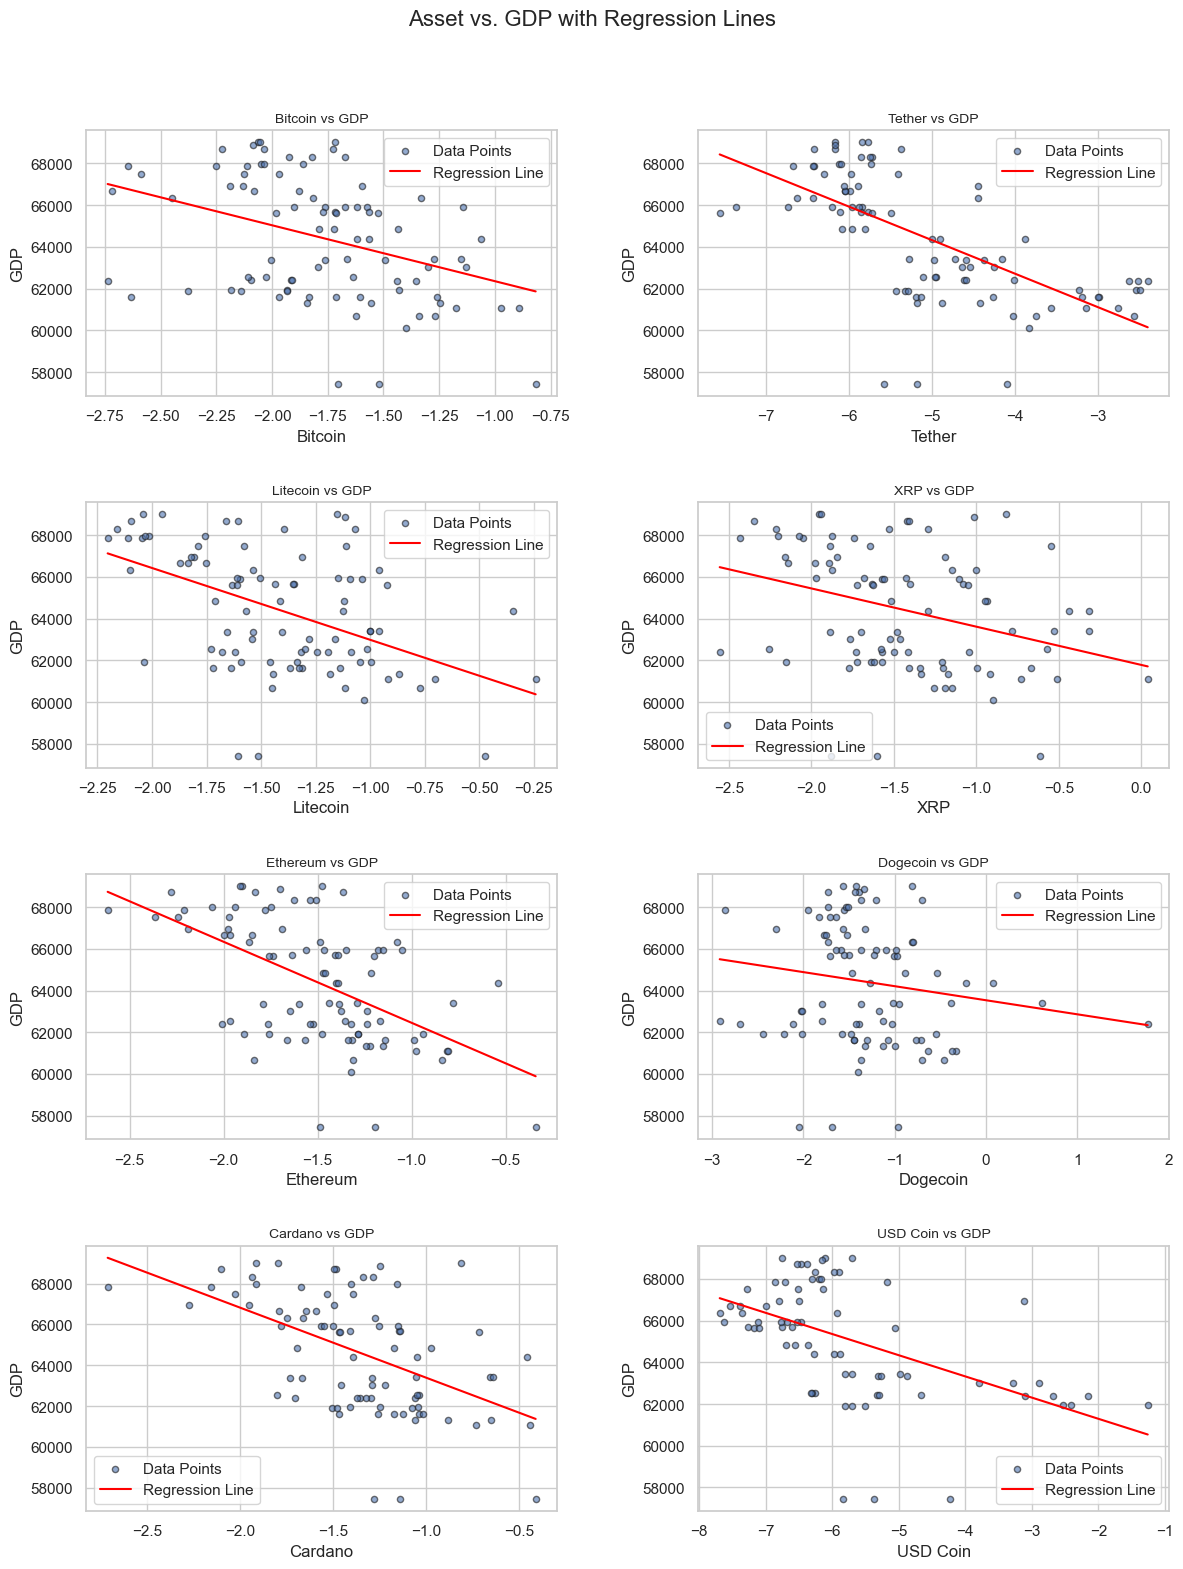

===== Bitcoin Regression Summary =====
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     14.10
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           0.000314
Time:                        15:43:54   Log-Likelihood:                -819.52
No. Observations:                  88   AIC:                             1643.
Df Residuals:                      86   BIC:                             1648.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const  

In [4]:
import seaborn as sns
import numpy as np

asset_cols = ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']
macro_cols = ['GDP']

sns.set(style="whitegrid")

total_plots = len(asset_cols) * len(macro_cols)
plots_per_row = 2
n_rows = (total_plots + plots_per_row - 1) // plots_per_row  # ceiling division

fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(6 * plots_per_row, 4 * n_rows))
fig.suptitle("Asset vs. GDP with Regression Lines", fontsize=16)

axes = axes.flatten() if total_plots > 1 else [axes]
model_results = []

plot_idx = 0
for asset in asset_cols:
    for macro in macro_cols:
        if plot_idx >= total_plots:
            break
        ax = axes[plot_idx]

        # Drop rows with NaNs in either variable
        temp_df = df[[asset, macro]].dropna()
        x = temp_df[asset]
        y = temp_df[macro]

        # Scatter plot
        ax.scatter(x, y, alpha=0.6, edgecolor='k', s=20, label='Data Points')

        df['Lagged_LogVol'] = df[asset].shift(1)

        # Drop first row due to NaN from lag
        temp_df = df.dropna(subset=['Lagged_LogVol', macro])

        # Define X and y
        X = temp_df['Lagged_LogVol']
        y = temp_df[macro]

        X = sm.add_constant(X)  # Adds intercept

        # Fit OLS model
        model = sm.OLS(y, X).fit()
        model_results.append((asset.strip(), model))

        # Predict y values for a line
        x_vals = np.linspace(x.min(), x.max(), 100)
        X_pred = sm.add_constant(x_vals)
        y_pred = model.predict(X_pred)

        # Plot regression line
        ax.plot(x_vals, y_pred, color='red', label='Regression Line')

        ax.set_xlabel(asset.strip())
        ax.set_ylabel(macro)
        ax.set_title(f"{asset.strip()} vs {macro}", fontsize=10)
        ax.legend()

        plot_idx += 1


# Hide unused subplots
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

for asset_name, model in model_results:
    print(f"===== {asset_name} Regression Summary =====")
    print(model.summary())
    print("\n")


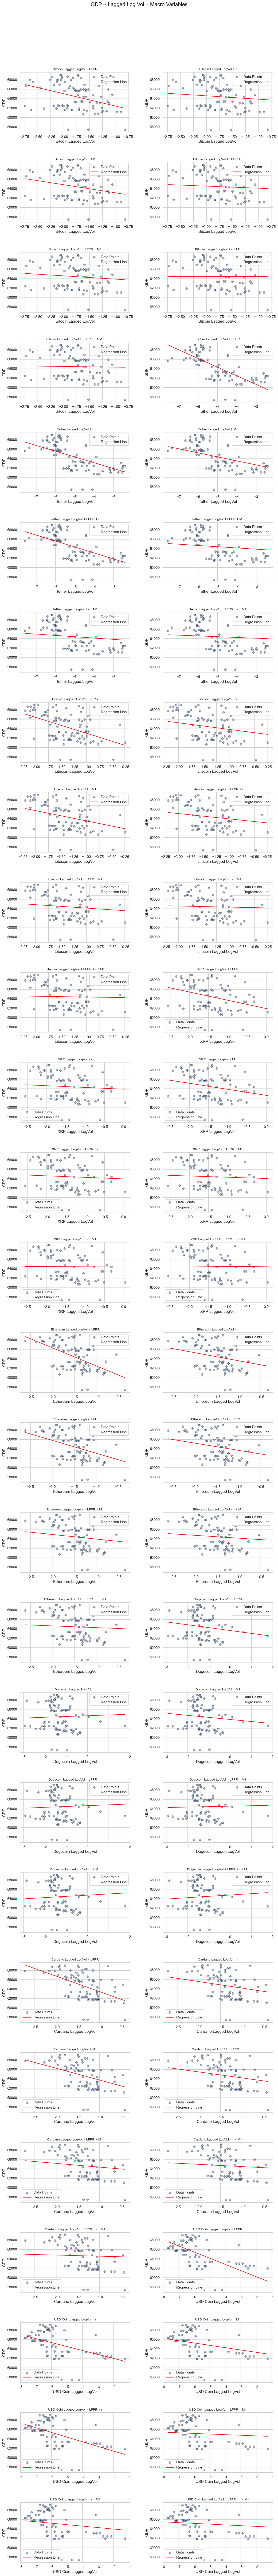

===== Bitcoin | GDP ~ Lagged LogVol + LFPR =====
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     7.653
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           0.000879
Time:                        15:44:02   Log-Likelihood:                -818.92
No. Observations:                  88   AIC:                             1644.
Df Residuals:                      85   BIC:                             1651.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from itertools import combinations

sns.set(style="whitegrid")

# Make sure no trailing spaces in column names
df.columns = df.columns.str.strip()

asset_cols = ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']
macro_vars = ['LFPR', 'r', 'M1']

# Generate all macro combos (single, pairs, triples)
macro_combos = []
for i in range(1, len(macro_vars) + 1):
    macro_combos.extend(combinations(macro_vars, i))

total_plots = len(asset_cols) * len(macro_combos)
plots_per_row = 2
n_rows = (total_plots + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(6 * plots_per_row, 4 * n_rows))
fig.suptitle("GDP ~ Lagged Log Vol + Macro Variables", fontsize=16)
axes = axes.flatten() if total_plots > 1 else [axes]

model_results = []
plot_idx = 0

for asset in asset_cols:
    asset = asset.strip()
    df['Lagged_LogVol'] = df[asset].shift(1)

    for combo in macro_combos:
        # Columns needed for this regression
        needed_cols = ['GDP', 'Lagged_LogVol'] + list(combo)
        temp_df = df[needed_cols].dropna()

        y = temp_df['GDP']
        X = temp_df[['Lagged_LogVol'] + list(combo)]
        X = sm.add_constant(X)  # Add intercept

        model = sm.OLS(y, X).fit()
        model_results.append((asset, combo, model))

        # Plot
        ax = axes[plot_idx]
        ax.scatter(temp_df['Lagged_LogVol'], y, alpha=0.5, edgecolor='k', label='Data Points')

        # Prepare data for prediction line (vary Lagged_LogVol, keep others at mean)
        x_vals = np.linspace(temp_df['Lagged_LogVol'].min(), temp_df['Lagged_LogVol'].max(), 100)
        pred_data = {var: temp_df[var].mean() for var in combo}
        pred_df = pd.DataFrame({
            'Lagged_LogVol': x_vals,
            **pred_data
        })

        pred_df = pd.DataFrame({
            'Lagged_LogVol': x_vals,
            **pred_data
        })

        # Add constant column if missing
        if 'const' not in pred_df.columns:
            pred_df = sm.add_constant(pred_df, has_constant='add')

        pred_df = pred_df[model.model.exog_names]  # Ensure column order

        y_pred = model.predict(pred_df)
        ax.plot(x_vals, y_pred, color='red', label='Regression Line')

        combo_label = ' + '.join(combo)
        ax.set_title(f"{asset} Lagged LogVol + {combo_label}", fontsize=10)
        ax.set_xlabel(f'{asset} Lagged LogVol')
        ax.set_ylabel('GDP')
        ax.legend()

        plot_idx += 1

# Remove unused axes
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

# Print summaries
for asset, combo, model in model_results:
    combo_str = ' + '.join(combo)
    print(f"===== {asset} | GDP ~ Lagged LogVol + {combo_str} =====")
    print(model.summary())
    print("\n")


## GDP ~ Litecoin | GDP ~ Lagged LogVol + LFPR + M1
### R^2 improved 0.0086, not significant

In [6]:
import numpy as np
import statsmodels.api as sm
# Create lagged log volatility as predictor
df['Lagged_LogVol_Litecoin'] = df['Litecoin'].shift(1)

# Drop NA (first row will be NaN due to lag)
df = df.iloc[1:]

# Define your columns here depending on your currency/model
# Example for Litecoin-like model:
cols_with_vol = ['GDP', 'Lagged_LogVol_Litecoin', 'LFPR', 'M1']
cols_no_vol = ['GDP', 'LFPR', 'M1']

# Subset dataframes and clean infinite and missing values
df_with_vol = df[cols_with_vol].replace([np.inf, -np.inf], np.nan).dropna()
df_no_vol = df[cols_no_vol].replace([np.inf, -np.inf], np.nan).dropna()

# Find common indices to align datasets
common_index = df_with_vol.index.intersection(df_no_vol.index)
df_with_vol = df_with_vol.loc[common_index]
df_no_vol = df_no_vol.loc[common_index]

# Define dependent and independent variables for model WITH Lagged_LogVol
y_with_vol = df_with_vol['GDP']
X_with_vol = df_with_vol.drop(columns='GDP')
X_with_vol = sm.add_constant(X_with_vol)

# Fit the model WITH Lagged_LogVol
model_with_vol = sm.OLS(y_with_vol, X_with_vol).fit()

# Define dependent and independent variables for model WITHOUT Lagged_LogVol
y_no_vol = df_no_vol['GDP']
X_no_vol = df_no_vol.drop(columns='GDP')
X_no_vol = sm.add_constant(X_no_vol)

# Fit the model WITHOUT Lagged_LogVol
model_no_vol = sm.OLS(y_no_vol, X_no_vol).fit()

# Print model summaries
print("Model WITH Lagged_LogVol_Litecoin:")
print(model_with_vol.summary())
print("\nModel WITHOUT Lagged_LogVol_Litecoin:")
print(model_no_vol.summary())

# Compare R-squared
print(f"\nR-squared WITH Lagged_LogVol_Litecoin: {model_with_vol.rsquared:.4f}")
print(f"R-squared WITHOUT Lagged_LogVol_Litecoin: {model_no_vol.rsquared:.4f}")
print(f"Difference in R-squared: {model_with_vol.rsquared - model_no_vol.rsquared:.4f}")


Model WITH Lagged_LogVol_Litecoin:
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     156.7
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           2.63e-34
Time:                        15:44:03   Log-Likelihood:                -743.19
No. Observations:                  88   AIC:                             1494.
Df Residuals:                      84   BIC:                             1504.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

## Ethereum | GDP ~ Lagged LogVol + LFPR + M1
### not significant, 0.015

In [7]:
import numpy as np
import statsmodels.api as sm
# Create lagged log volatility as predictor
df['Lagged_LogVol_Ethereum'] = df['Ethereum'].shift(1)

# Drop NA (first row will be NaN due to lag)
df = df.iloc[1:]

# Define your columns here depending on your currency/model
# Example for Litecoin-like model:
cols_with_vol = ['GDP', 'Lagged_LogVol_Ethereum', 'LFPR', 'M1']
cols_no_vol = ['GDP', 'LFPR', 'M1']

# Subset dataframes and clean infinite and missing values
df_with_vol = df[cols_with_vol].replace([np.inf, -np.inf], np.nan).dropna()
df_no_vol = df[cols_no_vol].replace([np.inf, -np.inf], np.nan).dropna()

# Find common indices to align datasets
common_index = df_with_vol.index.intersection(df_no_vol.index)
df_with_vol = df_with_vol.loc[common_index]
df_no_vol = df_no_vol.loc[common_index]

# Define dependent and independent variables for model WITH Lagged_LogVol
y_with_vol = df_with_vol['GDP']
X_with_vol = df_with_vol.drop(columns='GDP')
X_with_vol = sm.add_constant(X_with_vol)

# Fit the model WITH Lagged_LogVol
model_with_vol = sm.OLS(y_with_vol, X_with_vol).fit()

# Define dependent and independent variables for model WITHOUT Lagged_LogVol
y_no_vol = df_no_vol['GDP']
X_no_vol = df_no_vol.drop(columns='GDP')
X_no_vol = sm.add_constant(X_no_vol)

# Fit the model WITHOUT Lagged_LogVol
model_no_vol = sm.OLS(y_no_vol, X_no_vol).fit()

# Print model summaries
print("Model WITH Lagged_LogVol_Ethereum:")
print(model_with_vol.summary())
print("\nModel WITHOUT Lagged_LogVol_Ethereum:")
print(model_no_vol.summary())

# Compare R-squared
print(f"\nR-squared WITH Lagged_LogVol_Ethereum: {model_with_vol.rsquared:.4f}")
print(f"R-squared WITHOUT Lagged_LogVol_Ethereum: {model_no_vol.rsquared:.4f}")
print(f"Difference in R-squared: {model_with_vol.rsquared - model_no_vol.rsquared:.4f}")


Model WITH Lagged_LogVol_Ethereum:
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     158.3
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           3.08e-34
Time:                        15:44:03   Log-Likelihood:                -733.58
No. Observations:                  87   AIC:                             1475.
Df Residuals:                      83   BIC:                             1485.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

## Cardano | GDP ~ Lagged LogVol + LFPR + M1
### not significant, 0.011

In [8]:
import numpy as np
import statsmodels.api as sm
# Create lagged log volatility as predictor
df['Lagged_LogVol_Cardano'] = df['Cardano'].shift(1)

# Drop NA (first row will be NaN due to lag)
df = df.iloc[1:]

# Define your columns here depending on your currency/model
# Example for Litecoin-like model:
cols_with_vol = ['GDP', 'Lagged_LogVol_Cardano', 'LFPR', 'M1']
cols_no_vol = ['GDP', 'LFPR', 'M1']

# Subset dataframes and clean infinite and missing values
df_with_vol = df[cols_with_vol].replace([np.inf, -np.inf], np.nan).dropna()
df_no_vol = df[cols_no_vol].replace([np.inf, -np.inf], np.nan).dropna()

# Find common indices to align datasets
common_index = df_with_vol.index.intersection(df_no_vol.index)
df_with_vol = df_with_vol.loc[common_index]
df_no_vol = df_no_vol.loc[common_index]

# Define dependent and independent variables for model WITH Lagged_LogVol
y_with_vol = df_with_vol['GDP']
X_with_vol = df_with_vol.drop(columns='GDP')
X_with_vol = sm.add_constant(X_with_vol)

# Fit the model WITH Lagged_LogVol
model_with_vol = sm.OLS(y_with_vol, X_with_vol).fit()

# Define dependent and independent variables for model WITHOUT Lagged_LogVol
y_no_vol = df_no_vol['GDP']
X_no_vol = df_no_vol.drop(columns='GDP')
X_no_vol = sm.add_constant(X_no_vol)

# Fit the model WITHOUT Lagged_LogVol
model_no_vol = sm.OLS(y_no_vol, X_no_vol).fit()

# Print model summaries
print("Model WITH Lagged_LogVol_Cardano:")
print(model_with_vol.summary())
print("\nModel WITHOUT Lagged_LogVol_Cardano:")
print(model_no_vol.summary())

# Compare R-squared
print(f"\nR-squared WITH Lagged_LogVol_Cardano: {model_with_vol.rsquared:.4f}")
print(f"R-squared WITHOUT Lagged_LogVol_Cardano: {model_no_vol.rsquared:.4f}")
print(f"Difference in R-squared: {model_with_vol.rsquared - model_no_vol.rsquared:.4f}")


Model WITH Lagged_LogVol_Cardano:
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     135.3
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           4.91e-31
Time:                        15:44:03   Log-Likelihood:                -702.37
No. Observations:                  83   AIC:                             1413.
Df Residuals:                      79   BIC:                             1422.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

## USD Coin | GDP ~ Lagged LogVol + LFPR + r
### not significant, 0.0017

In [9]:
import numpy as np
import statsmodels.api as sm
# Create lagged log volatility as predictor
df['Lagged_LogVol_USD Coin'] = df['USD Coin'].shift(1)

# Drop NA (first row will be NaN due to lag)
df = df.iloc[1:]

# Define your columns here depending on your currency/model
# Example for Litecoin-like model:
cols_with_vol = ['GDP', 'Lagged_LogVol_USD Coin', 'LFPR', 'M1']
cols_no_vol = ['GDP', 'LFPR', 'M1']

# Subset dataframes and clean infinite and missing values
df_with_vol = df[cols_with_vol].replace([np.inf, -np.inf], np.nan).dropna()
df_no_vol = df[cols_no_vol].replace([np.inf, -np.inf], np.nan).dropna()

# Find common indices to align datasets
common_index = df_with_vol.index.intersection(df_no_vol.index)
df_with_vol = df_with_vol.loc[common_index]
df_no_vol = df_no_vol.loc[common_index]

# Define dependent and independent variables for model WITH Lagged_LogVol
y_with_vol = df_with_vol['GDP']
X_with_vol = df_with_vol.drop(columns='GDP')
X_with_vol = sm.add_constant(X_with_vol)

# Fit the model WITH Lagged_LogVol
model_with_vol = sm.OLS(y_with_vol, X_with_vol).fit()

# Define dependent and independent variables for model WITHOUT Lagged_LogVol
y_no_vol = df_no_vol['GDP']
X_no_vol = df_no_vol.drop(columns='GDP')
X_no_vol = sm.add_constant(X_no_vol)

# Fit the model WITHOUT Lagged_LogVol
model_no_vol = sm.OLS(y_no_vol, X_no_vol).fit()

# Print model summaries
print("Model WITH Lagged_LogVol_USD Coin:")
print(model_with_vol.summary())
print("\nModel WITHOUT Lagged_LogVol_USD Coin:")
print(model_no_vol.summary())

# Compare R-squared
print(f"\nR-squared WITH Lagged_LogVol_USD Coin: {model_with_vol.rsquared:.4f}")
print(f"R-squared WITHOUT Lagged_LogVol_USD Coin: {model_no_vol.rsquared:.4f}")
print(f"Difference in R-squared: {model_with_vol.rsquared - model_no_vol.rsquared:.4f}")


Model WITH Lagged_LogVol_USD Coin:
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     90.34
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           1.13e-23
Time:                        15:44:03   Log-Likelihood:                -614.58
No. Observations:                  72   AIC:                             1237.
Df Residuals:                      68   BIC:                             1246.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

# USD Coin | GDP ~ Lagged LogVol + LFPR + r Significant Result

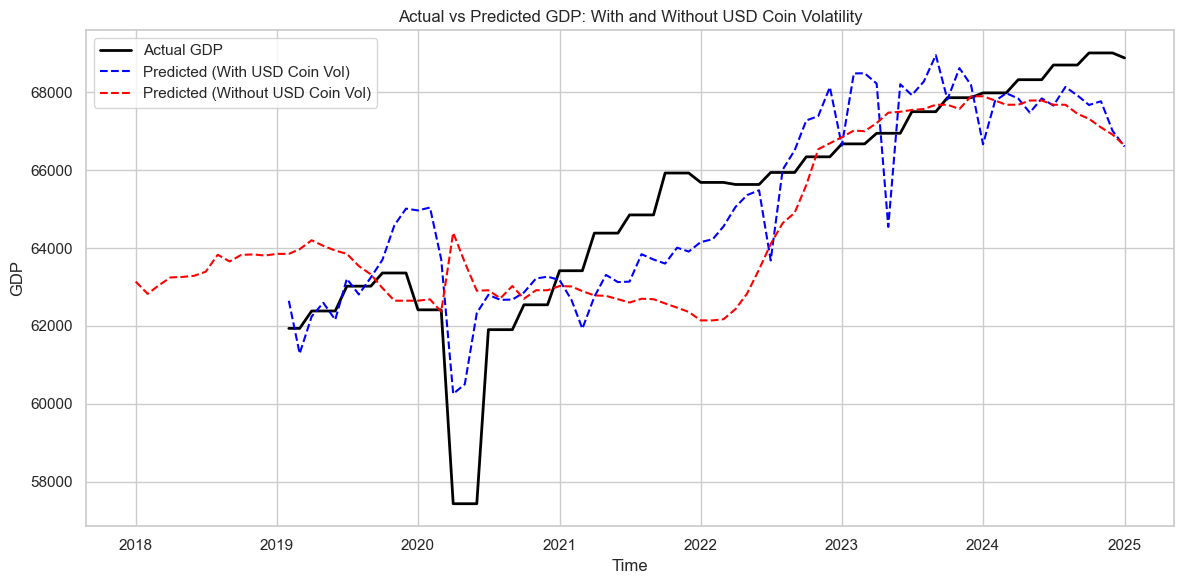


Model WITH USD Coin Volatility:
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     62.70
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           1.51e-19
Time:                        15:51:40   Log-Likelihood:                -624.68
No. Observations:                  72   AIC:                             1257.
Df Residuals:                      68   BIC:                             1266.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

In [20]:
# --- Step 1: Create lagged volatility predictor ---
df['Lagged_LogVol_USD'] = df['USD Coin'].shift(1)

# --- Step 2: Drop rows with any NaNs in the relevant columns ---
model_cols_with = ['Lagged_LogVol_USD', 'LFPR', 'r', 'GDP']
model_cols_without = ['LFPR', 'r', 'GDP']

df_with = df[model_cols_with].dropna()
df_without = df[model_cols_without].dropna()

# --- Step 3: Build models ---
# Model with crypto volatility
X1 = sm.add_constant(df_with[['Lagged_LogVol_USD', 'LFPR', 'r']])
y1 = df_with['GDP']
model1 = sm.OLS(y1, X1).fit()

# Model without crypto volatility
X2 = sm.add_constant(df_without[['LFPR', 'r']])
y2 = df_without['GDP']
model2 = sm.OLS(y2, X2).fit()

# --- Step 4: Plot actual vs predicted ---
# Align indexes and create common time axis
time_index_with = df_with.index
time_index_without = df_without.index

# Predicted values
pred_with = model1.predict(X1)
pred_without = model2.predict(X2)

# Plot actual vs. predicted GDP
plt.figure(figsize=(12, 6))
plt.plot(time_index_with, y1, label='Actual GDP', color='black', linewidth=2)
plt.plot(time_index_with, pred_with, label='Predicted (With USD Coin Vol)', linestyle='--', color='blue')
plt.plot(time_index_without, pred_without, label='Predicted (Without USD Coin Vol)', linestyle='--', color='red')

plt.xlabel('Time')
plt.ylabel('GDP')
plt.title('Actual vs Predicted GDP: With and Without USD Coin Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Step 5: Print comparison ---
print("\nModel WITH USD Coin Volatility:")
print(model1.summary())

print("\nModel WITHOUT USD Coin Volatility:")
print(model2.summary())

r2_with = model1.rsquared
r2_without = model2.rsquared
print(f"\nR-squared WITH USD Coin Vol: {r2_with:.4f}")
print(f"R-squared WITHOUT USD Coin Vol: {r2_without:.4f}")
print(f"Difference in R-squared: {r2_with - r2_without:.4f}")
